<a href="https://colab.research.google.com/github/tanmaylaud/biospec/blob/main/Siamese_Network_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# we used wandb api to log our training cycle and model stats
!pip install -q wandb

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/CSE291C00/Stage_1_Analysis_29_tissues_Project/'

/content/drive/MyDrive/CSE291C00/Stage_1_Analysis_29_tissues_Project


In [ ]:
import torch
import random
import numpy as np
import pandas as pd
import time
import torch.nn.functional as F
import pickle
import torch
from torch.utils.data import Dataset
import random
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import math
import wandb
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,precision_recall_curve
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

In [ ]:
#defining the seed for reproducability
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
#reading the merged_stomach_tissue data. 
#in this case we are using 15 stomach tissue files.
with open('stomach_merged_large.pickle','rb') as f:
    merged = pickle.load(f)

In [ ]:
#for each spectrum storing the data needed as a dictionary,
#grouping is done by the peptide.
grouped_spectra = {}
for d in merged.values:
  if d[3] not in grouped_spectra:
    grouped_spectra[d[3]] = []
  grouped_spectra[d[3]].append({
      'mass': d[2],
      'charge': d[1],
      'protein': d[4],
      'spectrum':d[5].toarray()
  })  

In [ ]:
# contains a list of peptides, where each peptide consists of the spectrums associated with it.
g_s = []
for g in grouped_spectra:
  g_s.append((g, grouped_spectra[g]))
 

In [ ]:
#creating a dataframe
#peptide column contains the peptide name and raw contains multiple spectrums of the peptide.
spec = pd.DataFrame(g_s,columns=['peptide','raw'])

In [ ]:
spec

peptide                                                raw
0                                      R.EDSQRPGAHLTVK.K  [{'mass': 1437.74, 'charge': 4, 'protein': 'tr...
1                                          K.ALVNQLHER.V  [{'mass': 1079.6, 'charge': 3, 'protein': 'tr|...
2                                 R.(C,57.021)IIPSVIKR.A  [{'mass': 1085.67, 'charge': 3, 'protein': 'tr...
3                                         Y.VNDAFGTAHR.A  [{'mass': 1087.53, 'charge': 3, 'protein': 'sp...
4                               R.(K,-50.079)MADLHAVPR.G  [{'mass': 1087.54, 'charge': 3, 'protein': 'sp...
...                                                  ...                                                ...
77975  K.VFDPS(C,57.021)GLPYYW(N,0.984)ADTDLVSWLSPHDP...  [{'mass': 3780.8, 'charge': 3, 'protein': 'tr|...
77976    R.SYAQSQGWWTGEGEFNFSEVFSPVEDHLD(C,57.021)GAGK.D  [{'mass': 3821.66, 'charge': 3, 'protein': 'tr...
77977  W.YQRVY(Q,321.076)SL(C,57.021)PTSWVTDWDEQRAEGT...  [{'mass': 3825.7, 'charge': 3, 'protein': 'sp|...
77978     V.SVNNEHNVANVDNNNGWDSW(N,0.984)SIWDYGNGFAATR.L  [{'mass': 3839.67, 'charge': 3, 'protein': 'sp...
77979                 K.(G,3.999)TWIHPEIDNPEYSPDPSIYAY.D  [{'mass': 2568.17, 'charge': 2, 'protein': 'tr...

[77980 rows x 2 columns]

In [ ]:
data = spec[spec.apply(lambda x: len(x['raw'])>1,axis=1)]

In [ ]:
data = data.sample(frac=1, random_state=SEED)
data = data.reset_index(drop=True)

In [ ]:
import numpy as np
import pandas as pd

def train_validate_test_split(df, train_percent=.8, validate_percent=.1):
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [ ]:
train_raw, valid_raw, test_raw = train_validate_test_split(data)

In [ ]:
#processing the data for siamese network
#y label has values 0 or 1. y = 1 means similar candidates (from the same peptide).
#y = 0 means contrast candidates (from different peptides)
def prepare_devsets(df):
  processed = []
  for i, row in enumerate(df.values):

      raw = row[1]
      peptide1 = row[0]

      #if peptide contains > 4 spectrums then find similar candidates by taking two pairs.
      if len(raw) > 4:
        for i in range(0,3,2):
          similar_candidates = raw[i:i+2]
          processed.append({'x':similar_candidates,
                            'y': 1,
                            'peptide1': peptide1,
                            'peptide2': peptide1,
                      })
      # taking a pair of similar spectrums as candidates
      else:
        similar_candidates = random.sample(raw,2)
        processed.append({'x':similar_candidates,
                          'y': 1,
                          'peptide1': peptide1,
                          'peptide2': peptide1,
                      })
      # taking 6 pairs of contrast candidates
      for i in range(0,6):
        current_candidate = random.sample(raw,1)[0]
        contrast_peptide = random.sample(list(df.values),1)

        contrast_candidate = random.sample(contrast_peptide[0][1],1)[0]
        processed.append({'x':[current_candidate,contrast_candidate],
                          'y' : 0,
                          'peptide1': peptide1,
                          'peptide2':contrast_peptide[0][0]
                          })
  return processed

In [ ]:
valid_processed = prepare_devsets(valid_raw)
test_processed  = prepare_devsets(test_raw)

In [ ]:
#writing the processed data into a pickle file for usage. 
with open('valid_processed_sia.pickle','wb') as f:
  pickle.dump(valid_processed, f)
with open('test_processed_sia.pickle','wb') as f:
  pickle.dump(test_processed, f)

In [ ]:
#loading processed data
with open('valid_processed_sia.pickle','rb') as f:
  valid_processed = pickle.load(f)
with open('test_processed_sia.pickle','rb') as f:
  test_processed = pickle.load(f)

In [ ]:
# Lets look at the ratio of positive to negative samples
print('Valid: ', pd.DataFrame(valid_processed)['y'].value_counts())
print('Test: ', pd.DataFrame(test_processed)['y'].value_counts())

Valid:  0    23412
1     5117
Name: y, dtype: int64
Test:  0    23418
1     5109
Name: y, dtype: int64


In [ ]:
#using gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#to get the dataset by index from the processed data.
class SpectrumDataset(Dataset):
  def __init__(self, data, train = False, contrast_ratio = 0.2, expansion_factor = 3):
    self.data = data
    if train:
      data = data.reset_index(drop=True)
    self.train = train
    self.contrast_ratio = contrast_ratio
    self.expansion_factor = expansion_factor
    self.data_len = len(data)
  
  def __len__(self):
    if not self.train:
      return self.data_len
    return self.data_len * self.expansion_factor

  def __getitem__(self,idx):
    if not self.train: 
      return self.data[idx]

    row = self.data.iloc[idx % self.data_len]
    
    peptide1 = row[0] 
    raw = row[1]

    if random.random() < self.contrast_ratio:
    
      similar_candidates = random.sample(raw,2)
      return {'x':similar_candidates,
                              'y': 1,
                              'peptide1': peptide1,
                              'peptide2': peptide1,
              }
      # taking a pair of similar spectrums as candidates
    else:
     current_candidate = random.sample(raw, 1)[0]
     contrast_peptide = self.data[self.data['peptide']!=peptide1].sample(n=1).values
     contrast_candidate = random.sample(contrast_peptide[0][1], 1)[0]
     return {'x':[current_candidate, contrast_candidate],
                          'y' : 0,
                          'peptide1': peptide1,
                          'peptide2':contrast_peptide[0][0]
            }
    

In [ ]:
train_data, valid_data, test_data = SpectrumDataset(train_raw, train=True, expansion_factor=1) ,  SpectrumDataset(valid_processed),  SpectrumDataset(test_processed)

In [ ]:
train_data.__getitem__(10)

{'peptide1': 'R.LVRPEVDVM(C,119.007)TAF.H',
 'peptide2': 'R.{14.993}KDLYANNVLSGGTTMYPGIADR.M',
 'x': [{'charge': 3,
   'mass': 1598.74,
   'protein': 'tr|A0A0C4DGB6|A0A0C4DGB6_HUMAN',
   'spectrum': array([[0., 0., 0., ..., 0., 0., 0.]])},
  {'charge': 3,
   'mass': 2371.2,
   'protein': 'sp|P63267-2|ACTH_HUMAN',
   'spectrum': array([[0., 0., 0., ..., 0., 0., 0.]])}],
 'y': 0}

In [ ]:
with open('valid_data.pickle', 'wb') as f:
  pickle.dump(valid_data,f)
with open('test_data.pickle', 'wb') as f:
  pickle.dump(test_data,f)

In [ ]:
with open('valid_data.pickle', 'rb') as f:
  valid_data = pickle.load(f)
with open('test_data.pickle', 'rb') as f:
  test_data = pickle.load(f)

In [ ]:
#preparing data for training with dataloaders and a batch of 256.
BATCH_SIZE = 1024
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## Model Encoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    
    self.convnet = nn.Sequential(nn.Conv1d(1, 32, 100, 20),
                                 nn.PReLU(),
                                 nn.MaxPool1d(50, stride=2),
                                 nn.Conv1d(32, 64, 5),
                                 nn.PReLU(),
                                 nn.MaxPool1d(2, stride=2))
    self.pos_embedding = nn.Embedding(2051, 1)

    self.linear = nn.Linear(640+1,256)

  def forward(self,spectrum, charge):
    spectrum = spectrum.to(device)
    batch_size = spectrum.shape[0]

    #create position tensor
    pos = torch.arange(0, spectrum.shape[-1]).unsqueeze(0).repeat(batch_size, 1).to(device)
        
    #pos = [0, 1, 2, 3, ..., src len - 1]
    #print(spectrum.shape)
    pos_embedded = self.pos_embedding(pos)
    #print(pos_embedded.shape)
    spectrum_with_pos = spectrum + pos_embedded.permute(0,2,1)
    #print(spectrum_with_pos.shape)
    convolved  = self.convnet(spectrum_with_pos.float())
    
    charge = torch.log(charge.float().to(device).unsqueeze(-1))
    
    convolved = convolved.view(convolved.size()[0],-1)

    concatenated = torch.cat([convolved, charge],dim=-1)
  
    return self.linear(concatenated)

class SiameseNetwork(nn.Module):
  def __init__(self, encoder):
    super(SiameseNetwork,self).__init__()
    self.encoder = encoder

  def forward(self,x):
    x1, x2 = x
    
    x1 = self.encoder(x1['spectrum'], x1['charge'])
    x2 = self.encoder(x2['spectrum'], x2['charge'])

    return x1, x2

class ContrastiveLoss(nn.Module):
    """
    Contrastive loss using Cosine Embedding Loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == -1 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9
        self.loss = torch.nn.CosineEmbeddingLoss(margin=margin, size_average=None, reduce=None, reduction='mean')

    def forward(self, output1, output2, target):
        target = target.masked_fill(target==0,-1)
        return self.loss(output1, output2, target)

## Training the model

In [ ]:
enc = Encoder()
model = SiameseNetwork(enc).to(device)

In [ ]:
# initialize model paramaters
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

model.apply(init_weights)

The model has 179,941 trainable parameters


SiameseNetwork(
  (encoder): Encoder(
    (convnet): Sequential(
      (0): Conv1d(1, 32, kernel_size=(100,), stride=(20,))
      (1): PReLU(num_parameters=1)
      (2): MaxPool1d(kernel_size=50, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
      (4): PReLU(num_parameters=1)
      (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (pos_embedding): Embedding(2051, 1)
    (linear): Linear(in_features=641, out_features=256, bias=True)
  )
)

In [ ]:
# initialize optimizer
optimizer = optim.Adam(model.parameters())

In [ ]:
# initialize wandb for viewing the loss curves.
N_EPOCHS = 30
#CLIP = 1
RUN_NAME= 'siamese_cnn_stage2_2'
CONTRASTIVE_MARGIN = -0.1
MODEL_NAME = RUN_NAME+'.pt'
def init_wandb(model,config,run_name):
    wandb.init(project="cse291c00_siamese",name=run_name,config=config)
    #try:
    #    wandb.watch(model)
    #except:
    #    print("Model already under watch!")

config = dict({
    'model_type':'siamese_cnn_256',
    'seed':SEED,
    'n_epochs':N_EPOCHS,
    #'clip':CLIP,
    'batch size': BATCH_SIZE,
    'trainable params': count_parameters(model),
    'contrastive_margin': CONTRASTIVE_MARGIN
})

In [ ]:
def train(model, optimizer, loss_fn, train_dataloader, device):
  model.train()
  epoch_loss = 0.0
  for i, batch in enumerate(train_dataloader):

    optimizer.zero_grad()
    x, y_true = batch['x'], batch['y'].to(device)
    x1_embedded, x2_embedded = model(x)
    
    loss = loss_fn(x1_embedded, x2_embedded, y_true)
      
    loss.backward()
    
    optimizer.step()
      
    epoch_loss += loss.item()
  return epoch_loss/len(train_dataloader)

In [ ]:
def evaluate(model, loss_fn, valid_dataloader, device):
    
  model.eval()
  epoch_loss = 0

  with torch.no_grad():
    
    for i, batch in enumerate(valid_dataloader):

      x,y_true = batch['x'], batch['y'].to(device)
      x1_embedded, x2_embedded = model(x)
      loss = loss_fn(x1_embedded, x2_embedded, y_true)
        
      epoch_loss += loss.item()
    return epoch_loss/len(valid_dataloader)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# initialize loss margin
contrastive_loss = ContrastiveLoss(margin=CONTRASTIVE_MARGIN)

In [ ]:
# running the training of the data.
# reporting the epoch train and validation loss 
best_valid_loss = float('inf')
init_wandb(model,config,RUN_NAME)

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    print('Epoch:', epoch+1)
    train_loss = train(model, optimizer, contrastive_loss, train_dataloader, device)
    valid_loss = evaluate(model, contrastive_loss, valid_dataloader, device)
    # logging into wandb for plots
    wandb.log({'epoch_loss':{
                    'epoch':epoch,
                    'train':{
                        'loss':train_loss
                    },
                    'eval':{
                        'loss':valid_loss
                    }
             }})
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # saving the model with best validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss}')
    print(f'\t Val. Loss: {valid_loss}')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch: 1
Epoch: 01 | Time: 2m 4s
	Train Loss: 0.5102410797149904
	 Val. Loss: 0.34189917892217636
Epoch: 2
Epoch: 02 | Time: 2m 4s
	Train Loss: 0.30644831926591937
	 Val. Loss: 0.28489647273506435
Epoch: 3
Epoch: 03 | Time: 2m 3s
	Train Loss: 0.29389726250402387
	 Val. Loss: 0.2794106336576598
Epoch: 4
Epoch: 04 | Time: 2m 3s
	Train Loss: 0.28290515465121113
	 Val. Loss: 0.2734602295926639
Epoch: 5
Epoch: 05 | Time: 2m 4s
	Train Loss: 0.25818507325264717
	 Val. Loss: 0.24189356288739614
Epoch: 6
Epoch: 06 | Time: 2m 4s
	Train Loss: 0.236072828212092
	 Val. Loss: 0.2300403533237321
Epoch: 7
Epoch: 07 | Time: 2m 3s
	Train Loss: 0.2277369350194931
	 Val. Loss: 0.2255339180784566
Epoch: 8
Epoch: 08 | Time: 2m 3s
	Train Loss: 0.22302417649376777
	 Val. Loss: 0.21467733170304978
Epoch: 9
Epoch: 09 | Time: 2m 3s
	Train Loss: 0.2176381609132213
	 Val. Loss: 0.208819537290505
Epoch: 10
Epoch: 10 | Time: 2m 5s
	Train Loss: 0.2114723050786603
	 Val. Loss: 0.20437468960881233
Epoch: 11
Epoch: 11 |

## Testing the Model

In [ ]:
# loading the model and running evaluation on test data.
model.load_state_dict(torch.load(MODEL_NAME))

test_loss = evaluate(model, contrastive_loss, test_dataloader, device)

print(f'Test Loss: {test_loss}')

Test Loss: 0.1606838128396443


In [ ]:
#model.load_state_dict(torch.load(MODEL_NAME))
#torch.save(model.encoder.state_dict(), 'encoder_' + MODEL_NAME)

In [ ]:
# finding the cosine similarity for the pairs of spectrums 
# considering 256 pairs of samples
test = next(iter(test_dataloader))
model.eval()
with torch.no_grad():
  emb  = model(test['x'])

cos = torch.nn.CosineSimilarity(dim=-1)

# storing it against the y-value for comparison
pd.DataFrame([cos(emb[0],emb[1]),test['y']]).T

0          1
0      tensor(0.9980, device='cuda:0')  tensor(1)
1      tensor(0.0107, device='cuda:0')  tensor(0)
2     tensor(-0.1437, device='cuda:0')  tensor(0)
3     tensor(-0.2254, device='cuda:0')  tensor(0)
4      tensor(0.0308, device='cuda:0')  tensor(0)
...                                ...        ...
1019  tensor(-0.1416, device='cuda:0')  tensor(0)
1020  tensor(-0.0389, device='cuda:0')  tensor(0)
1021  tensor(-0.0558, device='cuda:0')  tensor(0)
1022  tensor(-0.1959, device='cuda:0')  tensor(0)
1023   tensor(0.7298, device='cuda:0')  tensor(1)

[1024 rows x 2 columns]

In [ ]:
# calculation TPs and FPs for the 256 pair of samples ,i.e one batch
cos = torch.nn.CosineSimilarity(dim=-1)
batch_pred = []
batch_true = []
batch_mass = []
batch_peptide = []
batch_raw_pred = []
batch_peptide1 = []
batch_peptide2 = []
batch_charge1 = []
batch_charge2 = []
batch_emb1 = torch.zeros((27,1024, 256))
batch_emb2 = torch.zeros((27,1024, 256))
batch_s1 = torch.zeros((27,1024, 1,2051))
batch_s2 = torch.zeros((27,1024,1,2051))
for i, batch in enumerate(test_dataloader):
  model.eval()
  if  batch['x'][0]['spectrum'].shape[0] != BATCH_SIZE:
    break
  with torch.no_grad():
    emb  = model(batch['x'])
    s1 , s2 = batch['x'][0]['spectrum'], batch['x'][1]['spectrum']
    batch_charge1.append(batch['x'][0]['charge'])
    batch_charge2.append(batch['x'][1]['charge'])
    batch_pred.append(cos(emb[0],emb[1]).cpu())
    batch_emb1[i] = emb[0]
    batch_emb2[i] = emb[1]
    batch_s1[i] = s1
    batch_s2[i] = s2
    batch_raw_pred.append(cos(s1,s2).cpu())
    batch_true.append(batch['y'].cpu())
    batch_mass.append((batch['x'][0]['mass'],batch['x'][1]['mass']))
    batch_peptide.append((batch['peptide1'],batch['peptide2']))
    batch_peptide1 += batch['peptide1']
    batch_peptide2 += batch['peptide2']
    
y_pred = torch.stack(batch_pred).view(27*1024).numpy()
y_raw_pred = torch.stack(batch_raw_pred).view(27*1024).numpy()
y_true = torch.stack(batch_true).view(27*1024).numpy()
peptide1 = batch_peptide1
peptide2 = batch_peptide2
charge1 = torch.stack(batch_charge1).view(27*1024).numpy()
charge2 = torch.stack(batch_charge2).view(27*1024).numpy()
embeddings = torch.stack((batch_emb1, batch_emb2)).view(2*27*1024,256).numpy()
spectrum = torch.stack((batch_s1, batch_s2)).view(2*27*1024,2051).numpy()
peptides = peptide1 + peptide2

In [ ]:
y_pred

array([ 0.6854446 , -0.0436457 , -0.0982683 , ...,  0.41583353,
        0.28472036,  0.12192191], dtype=float32)

In [ ]:
df_eval = pd.DataFrame([peptide1, peptide2, y_pred, y_raw_pred, y_true, charge1, charge2], ).T
df_eval.columns =['peptide1', 'peptide2', 'Cosine_embedding', 'Cosine_spectrum', 'y_true', 'charge1', 'charge2']
df_eval

peptide1  ... charge2
0        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...       5
1        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...       3
2        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...       2
3        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...       2
4        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...       3
...                                       ...  ...     ...
27643                         I.HDIVLVGGSTR.I  ...       3
27644  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...       3
27645  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...       3
27646  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...       4
27647  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...       2

[27648 rows x 7 columns]

In [ ]:
with open('peptide_pair_scores.pickle','wb') as f:
  pickle.dump(df_eval,f)

In [ ]:
# dataframe for evaluation
with open('peptide_pair_scores.pickle','rb') as f:
  df_eval = pickle.load(f)

In [ ]:
df_eval = df_eval.infer_objects()

In [ ]:
df_eval['Cosine_embedding_scaled'] = (df_eval['Cosine_embedding'] + 1)/2

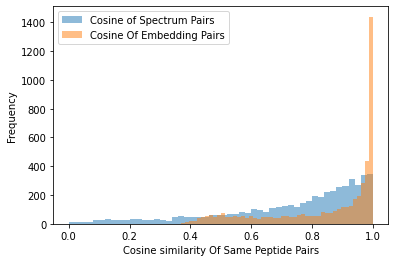

In [ ]:
fig, ax = plt.subplots() 
ax.hist(df_eval[df_eval['y_true']==1]['Cosine_spectrum'], 50, label='Cosine of Spectrum Pairs',alpha=0.5)
ax.hist(df_eval[df_eval['y_true']==1]['Cosine_embedding_scaled'], 50, label='Cosine Of Embedding Pairs',alpha=0.5)
ax.set_xlabel('Cosine similarity Of Same Peptide Pairs')
ax.set_ylabel('Frequency')
ax.legend()

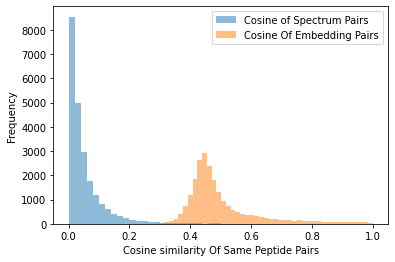

In [ ]:
fig, ax = plt.subplots() 
ax.hist(df_eval[df_eval['y_true']==0]['Cosine_spectrum'], 50, label='Cosine of Spectrum Pairs',alpha=0.5)
ax.hist(df_eval[df_eval['y_true']==0]['Cosine_embedding_scaled'], 50, label='Cosine Of Embedding Pairs',alpha=0.5)
ax.set_xlabel('Cosine similarity Of Same Peptide Pairs')
ax.set_ylabel('Frequency')
ax.legend()

In [ ]:
# dataframe containing modified peptide pairs (atleast one peptide is a modified variant)
df_mod = df_eval[df_eval['peptide1'].str.contains('\(') | df_eval['peptide2'].str.contains('\(')]
df_mod

peptide1  ... Cosine_embedding_scaled
0        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.842722
1        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.478177
2        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.450866
3        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.391512
4        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.586778
...                                       ...  ...                     ...
27642                         I.HDIVLVGGSTR.I  ...                0.543305
27644  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.991782
27645  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.707917
27646  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.642360
27647  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.560961

[15654 rows x 8 columns]

In [ ]:
# dataframe containing unmodified peptide variant pairs. 
df_unmod = df_eval[~(df_eval['peptide1'].str.contains('\(') | df_eval['peptide2'].str.contains('\('))]
df_unmod

peptide1  ... Cosine_embedding_scaled
22           -.VSVFQTQLPSLGAGLLQSR.-  ...                0.953081
23           -.VSVFQTQLPSLGAGLLQSR.-  ...                0.996345
24           -.VSVFQTQLPSLGAGLLQSR.-  ...                0.455867
26           -.VSVFQTQLPSLGAGLLQSR.-  ...                0.467030
29           -.VSVFQTQLPSLGAGLLQSR.-  ...                0.429134
...                              ...  ...                     ...
27618  -.NDPGHHIIEDMWLGVTVASQGPAGR.-  ...                0.411223
27621  -.NDPGHHIIEDMWLGVTVASQGPAGR.-  ...                0.466648
27637                I.HDIVLVGGSTR.I  ...                0.876802
27639                I.HDIVLVGGSTR.I  ...                0.441549
27643                I.HDIVLVGGSTR.I  ...                0.635437

[11994 rows x 8 columns]

In [ ]:
# dataframe of peptides with same charge
df_same_charge = df_eval[df_eval['charge1'] == df_eval['charge2']]
df_same_charge

peptide1  ... Cosine_embedding_scaled
0        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.842722
7         L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...                0.498115
8         L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...                0.868165
13        L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...                0.474253
15         K.GGIDINT(C,57.021)NQNGLNALHLAAK.E  ...                0.598523
...                                       ...  ...                     ...
27640                         I.HDIVLVGGSTR.I  ...                0.610490
27642                         I.HDIVLVGGSTR.I  ...                0.543305
27644  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.991782
27645  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.707917
27647  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.560961

[14231 rows x 8 columns]

In [ ]:
# datafram of peptides with different charge
df_diff_charge = df_eval[df_eval['charge1'] != df_eval['charge2']]
df_diff_charge

peptide1  ... y_pred_thres
1        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...            0
2        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...            0
3        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...            0
4        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...            0
5        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...            0
...                                       ...  ...          ...
27637                         I.HDIVLVGGSTR.I  ...            1
27639                         I.HDIVLVGGSTR.I  ...            0
27641                         I.HDIVLVGGSTR.I  ...            0
27643                         I.HDIVLVGGSTR.I  ...            0
27646  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...            0

[13417 rows x 11 columns]

In [ ]:
# dataframe of same peptide pairs
df_same_peptide = df_eval[df_eval['peptide1'] == df_eval['peptide2']]
df_same_peptide

peptide1  ... Cosine_embedding_scaled
0        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.842722
7         L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...                0.498115
8         L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...                0.868165
15         K.GGIDINT(C,57.021)NQNGLNALHLAAK.E  ...                0.598523
22                    -.VSVFQTQLPSLGAGLLQSR.-  ...                0.953081
...                                       ...  ...                     ...
27616           -.NDPGHHIIEDMWLGVTVASQGPAGR.-  ...                0.986995
27623       K.GADI(N,16.002)APDKHHITPLLSAVY.E  ...                0.848523
27630                -.DISE(M,15.995)FLQIYK.-  ...                0.550630
27637                         I.HDIVLVGGSTR.I  ...                0.876802
27644  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.991782

[4967 rows x 8 columns]

In [ ]:
# dataframe of same peptide pairs with different charge
df_same_peptide[df_same_peptide['charge1'] != df_same_peptide['charge2']]

peptide1  ... Cosine_embedding_scaled
82                            I.SIPDVGLHLK.G  ...                0.587496
104                           -.TELSFALVNR.-  ...                0.466844
163               S.VKKINESTQNWHQLENIGNFIK.A  ...                0.470674
186     R.EVEGERRAREQAEAEVASLNRRIQLVEEELDR.A  ...                0.982578
394    K.LATDKNDPHL(C,57.021)DFIETHYLNEQVK.A  ...                0.783092
...                                      ...  ...                     ...
27457                        -.QLYVLGHEAMK.-  ...                0.392303
27515                  R.HGFSGIPITETGTMGSK.L  ...                0.477845
27573              K.YI(C,46.542)ENQDSISSK.L  ...                0.550865
27594             -.RVIISAPSADAPMFVMGVNHEK.-  ...                0.597929
27637                        I.HDIVLVGGSTR.I  ...                0.876802

[530 rows x 9 columns]

In [ ]:
# dataframe of same peptides with same charge and cosine emb > cosine spectrum
df_same_peptide[df_same_peptide['charge1'] == df_same_peptide['charge2']][df_same_peptide['Cosine_embedding_scaled'] > df_same_peptide['Cosine_spectrum']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



peptide1  ... Cosine_embedding_scaled
0        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.842722
7         L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...                0.498115
8         L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...                0.868165
15         K.GGIDINT(C,57.021)NQNGLNALHLAAK.E  ...                0.598523
22                    -.VSVFQTQLPSLGAGLLQSR.-  ...                0.953081
...                                       ...  ...                     ...
27602         M.[42.011]GDKPIWEQIGSSFIQHYYQ.L  ...                0.999768
27609                 -.ILSAENIPNLPPGGGLAGK.-  ...                0.999379
27616           -.NDPGHHIIEDMWLGVTVASQGPAGR.-  ...                0.986995
27623       K.GADI(N,16.002)APDKHHITPLLSAVY.E  ...                0.848523
27644  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.991782

[3740 rows x 8 columns]

In [ ]:
3740/4437

0.842911877394636

In [ ]:
# dataframe of same peptide with different charge and cosine emb > cosine spectrum
df_same_peptide[df_same_peptide['charge1'] != df_same_peptide['charge2']][df_same_peptide['Cosine_embedding_scaled'] > df_same_peptide['Cosine_spectrum']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



peptide1  ... Cosine_embedding_scaled
163                  S.VKKINESTQNWHQLENIGNFIK.A  ...                0.470674
186        R.EVEGERRAREQAEAEVASLNRRIQLVEEELDR.A  ...                0.982578
394       K.LATDKNDPHL(C,57.021)DFIETHYLNEQVK.A  ...                0.783092
464    R.ALETQMEEM(K,32.001)TQLEELEDELQATEDAK.L  ...                0.510043
486               -.SLLSNVEGDNAVPMQHNNRPTQPLK.-  ...                0.880215
...                                         ...  ...                     ...
27457                           -.QLYVLGHEAMK.-  ...                0.392303
27515                     R.HGFSGIPITETGTMGSK.L  ...                0.477845
27573                 K.YI(C,46.542)ENQDSISSK.L  ...                0.550865
27594                -.RVIISAPSADAPMFVMGVNHEK.-  ...                0.597929
27637                           I.HDIVLVGGSTR.I  ...                0.876802

[474 rows x 9 columns]

In [ ]:
474/530.  # diff charges but model predicts higher cosine embeddings

0.8943396226415095

In [ ]:
# Same pair of peptides but the cosine of embedding > cosine of spectrum
# 4214/4967 --- Answer
df_same_peptide[df_same_peptide['Cosine_embedding_scaled'] > df_same_peptide['Cosine_spectrum']]

peptide1  ... Cosine_embedding_scaled
0        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.842722
7         L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...                0.498115
8         L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...                0.868165
15         K.GGIDINT(C,57.021)NQNGLNALHLAAK.E  ...                0.598523
22                    -.VSVFQTQLPSLGAGLLQSR.-  ...                0.953081
...                                       ...  ...                     ...
27609                 -.ILSAENIPNLPPGGGLAGK.-  ...                0.999379
27616           -.NDPGHHIIEDMWLGVTVASQGPAGR.-  ...                0.986995
27623       K.GADI(N,16.002)APDKHHITPLLSAVY.E  ...                0.848523
27637                         I.HDIVLVGGSTR.I  ...                0.876802
27644  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.991782

[4214 rows x 8 columns]

In [ ]:
df_mod_same = df_same_peptide[df_same_peptide['peptide1'].str.contains('\(')]
df_mod_same

peptide1  ... Cosine_embedding_scaled
0        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.842722
7         L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...                0.498115
8         L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...                0.868165
15         K.GGIDINT(C,57.021)NQNGLNALHLAAK.E  ...                0.598523
30                       R.F(N,0.984)ALQYLR.L  ...                0.951608
...                                       ...  ...                     ...
27573               K.YI(C,46.542)ENQDSISSK.L  ...                0.550865
27587          K.(V,-25.079)LGAFSDGLAHLDNLK.G  ...                0.949194
27623       K.GADI(N,16.002)APDKHHITPLLSAVY.E  ...                0.848523
27630                -.DISE(M,15.995)FLQIYK.-  ...                0.550630
27644  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.991782

[1844 rows x 8 columns]

In [ ]:
df_mod_same[df_mod_same['Cosine_embedding_scaled'] >= df_mod_same['Cosine_spectrum']] 

peptide1  ... Cosine_embedding_scaled
0        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.842722
7         L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...                0.498115
8         L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...                0.868165
15         K.GGIDINT(C,57.021)NQNGLNALHLAAK.E  ...                0.598523
30                       R.F(N,0.984)ALQYLR.L  ...                0.951608
...                                       ...  ...                     ...
27558              Y.QEVSQ(C,57.021)FGVLSSR.I  ...                0.490498
27573               K.YI(C,46.542)ENQDSISSK.L  ...                0.550865
27587          K.(V,-25.079)LGAFSDGLAHLDNLK.G  ...                0.949194
27623       K.GADI(N,16.002)APDKHHITPLLSAVY.E  ...                0.848523
27644  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.991782

[1590 rows x 8 columns]

In [ ]:
# dataframe of different peptide pairs
df_diff_peptide = df_eval[df_eval['peptide1'] != df_eval['peptide2']]
df_diff_peptide

peptide1  ... Cosine_embedding_scaled
1        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.478177
2        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.450866
3        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.391512
4        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.586778
5        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...                0.559805
...                                       ...  ...                     ...
27642                         I.HDIVLVGGSTR.I  ...                0.543305
27643                         I.HDIVLVGGSTR.I  ...                0.635437
27645  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.707917
27646  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.642360
27647  N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...                0.560961

[22681 rows x 9 columns]

In [ ]:
# thresholding the values to get y_pred for model and for raw spectrum
df_eval['y_pred_embedding'] = (df_eval['Cosine_embedding'] > 0.711).astype(int)
df_eval['y_pred_raw'] = (df_eval['Cosine_spectrum'] > 0.5).astype(int)
df_eval[df_eval['y_pred_raw']==df_eval['y_true']][df_eval['y_pred_embedding']!=df_eval['y_true']][df_eval['peptide1']!=df_eval['peptide2']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



peptide1  ... y_pred_raw
81     R.VIISAPSADAP(M,15.995)FVMGVNHEKYDNSLK.I  ...          0
88                               I.SIPDVGLHLK.G  ...          0
143         K.(L,78.007)TD(C,57.021)VVMRDPASK.R  ...          0
187        R.EVEGERRAREQAEAEVASLNRRIQLVEEELDR.A  ...          0
330                R.{95.994}IHFPLATYAPVISAEK.A  ...          0
...                                         ...  ...        ...
27505           R.(K,57.022)EGGLGPLNIPLLADVTR.R  ...          0
27571           K.FWEVISDEHGIDPAGGYVGDSALQLER.I  ...          0
27588            K.(V,-25.079)LGAFSDGLAHLDNLK.G  ...          0
27604           M.[42.011]GDKPIWEQIGSSFIQHYYQ.L  ...          0
27610                   -.ILSAENIPNLPPGGGLAGK.-  ...          0

[608 rows x 11 columns]

In [ ]:
df_eval['y_pred_embedding'] = (df_eval['Cosine_embedding'] > 0.711).astype(int)
df_eval['y_pred_raw'] = (df_eval['Cosine_spectrum'] > 0.5).astype(int)
df_eval[df_eval['y_pred_raw']==df_eval['y_true']][df_eval['y_pred_embedding']!=df_eval['y_true']][df_eval['peptide1']==df_eval['peptide2']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



peptide1  ... y_pred_raw
0      P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...          1
15       K.GGIDINT(C,57.021)NQNGLNALHLAAK.E  ...          1
37                      L.GIETAGGVMTVLIKR.N  ...          1
60                      K.YGVKPHDIFEANDLF.E  ...          1
67                 -.ETLFSV(M,15.995)PGLK.-  ...          1
...                                     ...  ...        ...
27580      K.{248.208}KISSIQSIVPALEIANAHR.K  ...          1
27594            -.RVIISAPSADAPMFVMGVNHEK.-  ...          1
27595            -.RVIISAPSADAPMFVMGVNHEK.-  ...          1
27623     K.GADI(N,16.002)APDKHHITPLLSAVY.E  ...          1
27630              -.DISE(M,15.995)FLQIYK.-  ...          1

[1077 rows x 10 columns]

In [ ]:
# SOME INTERESTING EXAMPLES
df_spec_same = df_eval[df_eval['y_pred_raw']==df_eval['y_true']][df_eval['y_pred_embedding']!=df_eval['y_true']][df_eval['peptide1']==df_eval['peptide2']].head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
df_eval[df_eval['y_pred_raw']==df_eval['y_true']][df_eval['y_pred_embedding']!=df_eval['y_true']][df_eval['peptide1']==df_eval['peptide2']].head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



peptide1  ... y_pred_raw
0        P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...          1
15         K.GGIDINT(C,57.021)NQNGLNALHLAAK.E  ...          1
37                        L.GIETAGGVMTVLIKR.N  ...          1
60                        K.YGVKPHDIFEANDLF.E  ...          1
67                   -.ETLFSV(M,15.995)PGLK.-  ...          1
82                             I.SIPDVGLHLK.G  ...          1
96                      -.HEEAPGHRPTTNPNASK.-  ...          1
104                            -.TELSFALVNR.-  ...          1
133           K.ASTPNGY(D,-16.046)NGIIWATWK.T  ...          1
148                      -.SYELPDGQVITIGNER.-  ...          1
155                         K.TLPGWNTDISNAR.A  ...          1
207                    Y.{96.012}MFQYDSTHGK.F  ...          1
221          K.IALFGAGPASIS(C,57.021)ASFLAR.L  ...          1
228          R.VLGESPVPHTVLNLKEPLYVGGAPDFSK.L  ...          1
242  K.KLN(C,57.021)QVIGASVDSHF(C,57.021)HL.A  ...          1
249                     -.LDGLVETPTGYIESLPR.-  ...          1
371            R.MQLAAESLQEADKWSTLSADIEETFK.T  ...          1
386              -.(M,15.995)VSWGGVSIPNSPFR.-  ...          1
387              -.(M,15.995)VSWGGVSIPNSPFR.-  ...          1
401                       R.IGNNFMDGLKDGIIL.C  ...          1

[20 rows x 10 columns]

In [ ]:
df_spec_same.to_csv('Examples_SpecSame_ModelDiff.csv', sep= ',')

In [ ]:
# SOME INTERESTING EXAMPLES
df_model_same = df_eval[df_eval['y_pred_raw']!=df_eval['y_true']][df_eval['y_pred_embedding']==df_eval['y_true']][df_eval['peptide1']==df_eval['peptide2']].sort_values(['Cosine_embedding'], ascending = False).head(30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
# SOME INTERESTING EXAMPLES
df_eval[df_eval['y_pred_raw']!=df_eval['y_true']][df_eval['y_pred_embedding']==df_eval['y_true']][df_eval['peptide1']==df_eval['peptide2']].sort_values(['Cosine_embedding'], ascending = False).head(30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



peptide1  ... y_pred_raw
8022                                        H.YYAVAVVK.K  ...          0
9033                              L.LDEE(C,57.021)WFPK.A  ...          0
23759                        R.(C,39.994)MALSTAVLVGEAK.K  ...          0
3377                             R.DAGEGLLAVQITDQEGKPK.R  ...          0
21242  R.(C,57.021)PETLFQPSFIGMESAGIHETTYNSI(M,160.09...  ...          0
23629                                R.LAGTQPLEVLEAVQR.S  ...          0
3478           Q.EMVRAAASSSPERSYELPDG(Q,0.984)VITIGNER.F  ...          0
13901                                      R.TIFDFHAIK.G  ...          0
10838                                       K.TDEGIAYR.G  ...          0
16573                      K.IE(W,31.994)LESHQDADIEDFK.A  ...          0
12136                           R.{162.114}AVFPSIVGRPR.H  ...          0
19500                            K.(M,15.995)PTFSTPGAK.G  ...          0
23840            K.T(M,15.995)VGFGPEDDHFVAELTYNYGVGDYK.L  ...          0
23359                           -.V(M,15.995)LVNSMNTVK.-  ...          0
2886                                     L.PSLAADFVESK.D  ...          0
25886         K.VADALTNA(V,59.018)AHVDDMPNALSALSDLHAHK.L  ...          0
27181                                   F.YEGEDFSETLTR.A  ...          0
5040                          -.VADALTNAVAHVDDMPNALSAL.-  ...          0
17234                                       L.SEYDAVER.E  ...          0
24411                           R.IIGLDQVAGMSETALPGAFK.T  ...          0
22988                      R.GGLGGGYGGASGMGGITAVTVNQSL.L  ...          0
27055               K.IKWGDAGAEYVVESTGVFTT(M,15.995)EK.A  ...          0
3074                                   R.IEGENYLPQPIYR.H  ...          0
24711                    -.GKPAVAALGDLTDLPTYEHIQTALSSK.-  ...          0
13161               N.W(F,-78.203)MKKAQEHKREFTESQLQEGK.H  ...          0
6842                                    K.HEAFETDFTVHK.D  ...          0
2305                                     K.EGYYGYTGAFR.C  ...          0
21641              W.SQWLGGSSWPGYVRPLPPAAIESPAVAAPAYSR.A  ...          0
15788                                     V.YGALMWALGK.V  ...          0
21751                                 K.NISFTVWDVGGQDK.I  ...          0

[30 rows x 10 columns]

In [ ]:
df_eval[df_eval['y_pred_raw']!=df_eval['y_true']][df_eval['y_pred_embedding']==df_eval['y_true']][df_eval['peptide1']==df_eval['peptide2']].sort_values(['Cosine_embedding'], ascending = False).head(30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



peptide1  ... y_pred_raw
8022                                        H.YYAVAVVK.K  ...          0
9033                              L.LDEE(C,57.021)WFPK.A  ...          0
23759                        R.(C,39.994)MALSTAVLVGEAK.K  ...          0
3377                             R.DAGEGLLAVQITDQEGKPK.R  ...          0
21242  R.(C,57.021)PETLFQPSFIGMESAGIHETTYNSI(M,160.09...  ...          0
23629                                R.LAGTQPLEVLEAVQR.S  ...          0
3478           Q.EMVRAAASSSPERSYELPDG(Q,0.984)VITIGNER.F  ...          0
13901                                      R.TIFDFHAIK.G  ...          0
10838                                       K.TDEGIAYR.G  ...          0
16573                      K.IE(W,31.994)LESHQDADIEDFK.A  ...          0
12136                           R.{162.114}AVFPSIVGRPR.H  ...          0
19500                            K.(M,15.995)PTFSTPGAK.G  ...          0
23840            K.T(M,15.995)VGFGPEDDHFVAELTYNYGVGDYK.L  ...          0
23359                           -.V(M,15.995)LVNSMNTVK.-  ...          0
2886                                     L.PSLAADFVESK.D  ...          0
25886         K.VADALTNA(V,59.018)AHVDDMPNALSALSDLHAHK.L  ...          0
27181                                   F.YEGEDFSETLTR.A  ...          0
5040                          -.VADALTNAVAHVDDMPNALSAL.-  ...          0
17234                                       L.SEYDAVER.E  ...          0
24411                           R.IIGLDQVAGMSETALPGAFK.T  ...          0
22988                      R.GGLGGGYGGASGMGGITAVTVNQSL.L  ...          0
27055               K.IKWGDAGAEYVVESTGVFTT(M,15.995)EK.A  ...          0
3074                                   R.IEGENYLPQPIYR.H  ...          0
24711                    -.GKPAVAALGDLTDLPTYEHIQTALSSK.-  ...          0
13161               N.W(F,-78.203)MKKAQEHKREFTESQLQEGK.H  ...          0
6842                                    K.HEAFETDFTVHK.D  ...          0
2305                                     K.EGYYGYTGAFR.C  ...          0
21641              W.SQWLGGSSWPGYVRPLPPAAIESPAVAAPAYSR.A  ...          0
15788                                     V.YGALMWALGK.V  ...          0
21751                                 K.NISFTVWDVGGQDK.I  ...          0

[30 rows x 11 columns]

In [ ]:
df_model_same.to_csv('Examples_ModelSame_SpecDiff.csv')

In [ ]:
df_eval.sort_values(['Cosine_embedding'], ascending = False)

peptide1  ... y_pred_raw
22069                       S.SEQLAQFR.S  ...          1
27475                    -.NQQPSNYGPMK.-  ...          1
16482        K.{95.988}TKENVVQSVTSVAEK.T  ...          1
25482       -.VGNIIDT(M,15.995)ITDAFLK.-  ...          1
19251     Y.{47.028}ANNVLSGGTTMYPGIADR.M  ...          1
...                                  ...  ...        ...
12825                   -.AVIEHNLLSASK.-  ...          0
11210  K.LNDHFPLVVWQTGSGTQTNMNVNEVISNR.A  ...          0
2800             -.ATYIQTIEEGINTHTHAAK.-  ...          0
20712                  -.AFHNEAQVNPERK.-  ...          0
6347                 -.IRPTVQEDGGDVIYK.-  ...          0

[27648 rows x 11 columns]

In [ ]:
df_eval[df_eval['y_pred_raw']!=df_eval['y_true']][df_eval['y_pred_embedding']!=df_eval['y_true']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



peptide1  ... y_pred_thres
7           L.SNVEGDNAVP(M,15.995)QHNNRPTQPLK.G  ...            0
75     R.VIISAPSADAP(M,15.995)FVMGVNHEKYDNSLK.I  ...            0
162                  S.VKKINESTQNWHQLENIGNFIK.A  ...            1
163                  S.VKKINESTQNWHQLENIGNFIK.A  ...            0
235          M.VHLTPEEKSAVTALWGKVNVDEVGGEALGR.L  ...            0
...                                         ...  ...          ...
27515                     R.HGFSGIPITETGTMGSK.L  ...            0
27543                            -.ADHPFLFVIR.-  ...            1
27550       -.KYTLPPGVDPTQVSSSLSPEGTLTVEAPMPK.-  ...            0
27558                Y.QEVSQ(C,57.021)FGVLSSR.I  ...            0
27573                 K.YI(C,46.542)ENQDSISSK.L  ...            0

[766 rows x 11 columns]

In [ ]:
#model.load_state_dict(torch.load(MODEL_NAME))
# ploting the ROC and precision-recall curve for the samples
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,precision_recall_curve, auc
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#using matplotlib
def get_plots(df, y_pred_column):
  fpr, tpr, thresholds = roc_curve(y_true=df['y_true'], y_score=df[y_pred_column])
  plt.figure()
  plt.plot(fpr,tpr)
  plt.grid(True)
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  precision, recall, thresholds = precision_recall_curve(y_true=df['y_true'], probas_pred=df[y_pred_column])
  plt.figure()
  plt.plot(recall,precision)
  plt.grid(True)
  plt.ylabel('Precision')
  plt.xlabel('Recall')

#using plotly for interactive plot to get threshold
def get_plotly_plots(df, y_pred_column):
  fpr, tpr, thresholds = roc_curve(y_true=df['y_true'], y_score=df[y_pred_column])

  plot_data = pd.DataFrame([fpr,tpr,thresholds]).T
  plot_data.columns = ["fpr","tpr","thresholds"]
  fig1 = go.Scatter(x= plot_data['fpr'], y=plot_data['tpr'], mode='lines', text= plot_data['thresholds'])
  
 
  precision, recall, thresholds = precision_recall_curve(y_true=df['y_true'], probas_pred=df[y_pred_column])
  plot_data = pd.DataFrame([precision,recall,thresholds]).T
  plot_data.columns = ["Precision","Recall","Thresholds"]
  fig2 = px.line(plot_data,y="Precision",x="Recall",hover_name="Thresholds")
  fig2 = go.Scatter(x= plot_data['Recall'], y=plot_data['Precision'], mode='lines', text= plot_data['Thresholds'])

  return fig1, fig2, auc(fpr,tpr)

#to get precision, recall and confusion matrix
def get_confusion_matrix(df, y_pred, y_true, threshold=0.0):
  def thres(y):
    if y <= threshold:
      return 0
    return 1  
  df['y_pred_thres'] = df[y_pred].apply(thres)
  print(classification_report(y_true=df[y_true],y_pred=df['y_pred_thres']))
  print(confusion_matrix(y_true=df[y_true],y_pred=df['y_pred_thres']))



In [ ]:
roc, pr, auc_val = get_plotly_plots(df_eval, 'Cosine_embedding')
fig = go.Figure(roc)
print("AUC:", auc_val)
fig.update_layout(title='ROC Curve',
                   xaxis_title='FPR',
                   yaxis_title='TPR')

AUC: 0.9208151871571045


In [ ]:
fig = go.Figure(pr)
fig.update_layout(title='Precision Recall Curve',
                   xaxis_title='Recall',
                   yaxis_title='Precision')

### Let's create a baseline based on raw spectrum

In [ ]:
# ROC and PR curve for Baseline and our Embeddings
roc_raw,pr_raw, auc_raw = get_plotly_plots(df_eval,'Cosine_spectrum')

In [ ]:
import pickle
with open('old_roc.plotly','rb') as f:
  roc_old = pickle.load(f)
with open('old_pr.plotly', 'rb') as f:
  pr_old = pickle.load(f)

In [ ]:
go.Figure(pr_old)

In [ ]:
roc_old.update({"name":"Cosine on Embeddings of Stage 1 Model"})
fig = go.Figure([roc_raw,roc, roc_old])
fig.update_layout(title='ROC Curve',
                   xaxis_title='FPR',
                   yaxis_title='TPR',
                  autosize=False)


In [ ]:
pr.update({"name":"Cosine on Embedding of Stage 2"})
pr_raw.update({"name":"Cosine on Spectrum"})
pr_old.update({"name": "Cosine on Embedding of Stage 1"})
fig = go.Figure([pr_raw,pr, pr_old])
fig.update_layout(title='Precision Recall Curve',
                   xaxis_title='Recall',
                   yaxis_title='Precision',
                  autosize=False)

In [ ]:
# Results for Baseline
get_confusion_matrix(df_eval, 'Cosine_embedding','y_true', threshold=0.12)

              precision    recall  f1-score   support

           0       0.97      0.81      0.88     22689
           1       0.50      0.87      0.63      4959

    accuracy                           0.82     27648
   macro avg       0.73      0.84      0.76     27648
weighted avg       0.88      0.82      0.83     27648

[[18275  4414]
 [  630  4329]]


In [ ]:
# Threshold for Model stage 2
get_confusion_matrix(df_eval, 'Cosine_embedding','y_true', threshold=0.5)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     22689
           1       0.72      0.74      0.73      4959

    accuracy                           0.90     27648
   macro avg       0.83      0.84      0.84     27648
weighted avg       0.90      0.90      0.90     27648

[[21292  1397]
 [ 1303  3656]]


In [ ]:
# Threshold for Model stage 2
get_confusion_matrix(df_eval, 'Cosine_embedding','y_true', threshold=0.711)

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     22689
           1       0.83      0.64      0.72      4959

    accuracy                           0.91     27648
   macro avg       0.88      0.80      0.83     27648
weighted avg       0.91      0.91      0.91     27648

[[22048   641]
 [ 1810  3149]]


In [ ]:
# Threshold for Spectrum
get_confusion_matrix(df_eval, 'Cosine_spectrum','y_true', threshold=0.5)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     22689
           1       0.99      0.84      0.91      4959

    accuracy                           0.97     27648
   macro avg       0.98      0.92      0.94     27648
weighted avg       0.97      0.97      0.97     27648

[[22630    59]
 [  808  4151]]


In [ ]:
# Threshold for Model stage 2
get_confusion_matrix(df_eval, 'Cosine_embedding','y_true', threshold=0.65)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     22689
           1       0.80      0.67      0.73      4959

    accuracy                           0.91     27648
   macro avg       0.87      0.82      0.84     27648
weighted avg       0.91      0.91      0.91     27648

[[21872   817]
 [ 1630  3329]]


In [ ]:
# Threshold for Model stage 2
get_confusion_matrix(df_diff_charge, 'Cosine_embedding_scaled','y_true', threshold=0.7)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     12887
           1       0.17      0.35      0.23       530

    accuracy                           0.91     13417
   macro avg       0.57      0.64      0.59     13417
weighted avg       0.94      0.91      0.92     13417

[[11987   900]
 [  342   188]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Threshold for Model stage 2
get_confusion_matrix(df_diff_charge, 'Cosine_spectrum','y_true', threshold=0.5)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     12887
           1       0.93      0.38      0.53       530

    accuracy                           0.97     13417
   macro avg       0.95      0.69      0.76     13417
weighted avg       0.97      0.97      0.97     13417

[[12871    16]
 [  331   199]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
stacked = torch.stack((emb[0],emb[1])).view(879*2,256)

In [ ]:
stacked_mass = torch.stack(batch_mass[-1]).view(879*2,1)
stacked_peptide = batch_peptide[-1][0] + batch_peptide[-1][1]

In [ ]:
!pip install faiss-gpu

     |████████████████████████████████| 89.4MB 121kB/s 


In [ ]:
peptides = pd.read_csv('peptides.csv')

In [ ]:
import faiss
import numpy as np
import torch

In [ ]:
peptide_emb = pd.DataFrame([peptides, embeddings, spectrum]).T

In [ ]:
peptide_emb.columns = ['peptide','embedding', 'spectrum']

In [ ]:
peptide_emb['embedding'].shape

(55296,)

In [ ]:
peptide_emb['embedding_norm'] = peptide_emb['embedding'].apply(lambda x: np.linalg.norm(x, axis=-1))
peptide_emb['embedding_norm'] = peptide_emb['embedding']/peptide_emb['embedding_norm']
peptide_emb

peptide  ...                                     embedding_norm
0          P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...  [0.047328908, 0.03889241, -0.005050241, -0.084...
1          P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...  [0.06646974, 0.0035965345, -0.065778166, -0.07...
2          P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...  [0.047328908, 0.03889241, -0.005050241, -0.084...
3          P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...  [0.06646974, 0.0035965345, -0.065778166, -0.07...
4          P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...  [0.047328908, 0.03889241, -0.005050241, -0.084...
...                                         ...  ...                                                ...
55291               R.TATESFASDPILYRPVAVALDTK.G  ...  [-0.0017055944, -0.02154339, 0.012088262, -0.0...
55292    N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...  [-0.009087786, 0.04053098, 0.012047851, -0.097...
55293  K.EGGQYGLVAA(C,57.021)AAGGQGHAMIVEAYPK.-  ...  [0.031915978, 0.06373578, 0.065737605, -0.0351...
55294                        K.NVTELNEPLSNEER.N  ...  [0.038004406, -0.01608555, 0.072373174, 0.0739...
55295                         -.TDKAEVVNGYEAK.-  ...  [0.026808377, -0.018941041, 0.005388205, -0.02...

[55296 rows x 4 columns]

In [ ]:
with open('peptide_embedding_table.pickle', 'wb') as f:
  pickle.dump(peptide_emb,f)

In [ ]:
with open('peptide_embedding_table.pickle', 'rb') as f:
  peptide_emb = pickle.load(f)

In [ ]:
peptide_emb['peptide'].value_counts()

K.AKAEAAEQAALAANQESNIAR.T                       24
-.NDGVLLLQALTR.-                                24
K.{17.981}L(C,57.021)YVALDFEQEMATAASSSSLEK.S    24
K.TLEEEAKTHEAQIQE(M,15.995)R.Q                  24
V.SMMLQLGGTVIGSAR.C                             24
                                                ..
K.GF(Y,183.041)PSDIAVEWESNGQPENNYK.T             2
R.ALQRPSAAAPQAE(N,0.984)GPAAAPAVAAPAATEAPK.M     2
-.DFSSVFQFLREEET.-                               2
Y.LYSSADQSSL(M,15.995)EESADQAQR.R                1
K.LKLGEIVTTIPTIGFNV.E                            1
Name: peptide, Length: 3903, dtype: int64

In [ ]:
peptide_emb

peptide  ... clusted_id
0          P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...       3432
1          P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...       4189
2          P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...       3432
3          P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...       4189
4          P.EGVL(S,289.283)IQAAPASAQAPPPAAAK.-  ...       3432
...                                         ...  ...        ...
55291               R.TATESFASDPILYRPVAVALDTK.G  ...        639
55292    N.(A,81.106)LEVQGRETRLVLEVAQHLGESTVR.T  ...        952
55293  K.EGGQYGLVAA(C,57.021)AAGGQGHAMIVEAYPK.-  ...       4688
55294                        K.NVTELNEPLSNEER.N  ...       3920
55295                         -.TDKAEVVNGYEAK.-  ...       1646

[55296 rows x 6 columns]

In [ ]:
# Run clustering
#fig, axs = plt.subplots(10,2)
#fig.set_size_inches(20,20)
%%time
splitting_emb = {}
mixing_emb = {}
for plot_index, k in enumerate(range(3000, 5000, 200)):
  print(f"Evaluating for {k} clusters...")
  kmeans = faiss.Kmeans(d=256, k=k, niter=50, verbose=True,gpu=True, spherical=True)
  kmeans.train(np.stack(peptide_emb['embedding_norm']))

  # The assignment for each vector.
  dists, ids = kmeans.index.search(np.stack(peptide_emb['embedding_norm']), 1)  # Need to run NN search again
  peptide_emb['distance'] = dists
  peptide_emb['clusted_id'] = ids
  cluster_to_peptide = {}
  peptide_to_cluster = {}
  for i, data in enumerate(peptide_emb.values):
    peptide, cluster_id = data[0], data[5]

    if cluster_id not in cluster_to_peptide:
      cluster_to_peptide[cluster_id] = []
    if peptide not in peptide_to_cluster:
      peptide_to_cluster[peptide] = []
    
    cluster_to_peptide[cluster_id].append(peptide)
    peptide_to_cluster[peptide].append(cluster_id)
  

  #Splitting
  y, x = np.histogram([len(np.unique(peptide_to_cluster[p])) for p in peptide_to_cluster])
  splitting_emb[k] = (x[:-1],y)
  #Mixing
  cluster_mixing_scores = [np.max(np.unique(cluster_to_peptide[c],return_counts=True)[1])/len(cluster_to_peptide[c]) for c in cluster_to_peptide]
  #print(min(cluster_mixing_scores))
  y, x = np.histogram(cluster_mixing_scores, bins=np.linspace(0, 1, num=20))
  mixing_emb[k] = (x[:-1],y)

Evaluating for 3000 clusters...
Evaluating for 3200 clusters...
Evaluating for 3400 clusters...
Evaluating for 3600 clusters...
Evaluating for 3800 clusters...
Evaluating for 4000 clusters...
Evaluating for 4200 clusters...
Evaluating for 4400 clusters...
Evaluating for 4600 clusters...
Evaluating for 4800 clusters...
CPU times: user 31.5 s, sys: 1.75 s, total: 33.2 s
Wall time: 33.2 s


In [ ]:
# Run clustering
%%time
splitting = {}
mixing = {}
for plot_index, k in enumerate(range(3000, 5000, 200)):
  kmeans = faiss.Kmeans(d=2051, k=k, niter=50, verbose=True,gpu=True, spherical=True)
  kmeans.train(np.stack(peptide_emb['spectrum']))

  # The assignment for each vector.
  dists, ids = kmeans.index.search(np.stack(peptide_emb['spectrum']), 1)  # Need to run NN search again
  peptide_emb['distance'] = dists
  peptide_emb['clusted_id'] = ids
  cluster_to_peptide = {}
  peptide_to_cluster = {}
  for i, data in enumerate(peptide_emb.values):
    peptide, cluster_id = data[0], data[5]

    if cluster_id not in cluster_to_peptide:
      cluster_to_peptide[cluster_id] = []
    if peptide not in peptide_to_cluster:
      peptide_to_cluster[peptide] = []
    
    cluster_to_peptide[cluster_id].append(peptide)
    peptide_to_cluster[peptide].append(cluster_id)
  #Splitting
  y,x = np.histogram([len(np.unique(peptide_to_cluster[p])) for p in peptide_to_cluster])
  splitting[k] = (x[:-1],y)
  #Mixing
  cluster_mixing_scores = [np.max(np.unique(cluster_to_peptide[c],return_counts=True)[1])/len(cluster_to_peptide[c]) for c in cluster_to_peptide]
  #print(cluster_mixing_scores)
  y, x = np.histogram(cluster_mixing_scores, bins=np.linspace(0, 1, num=20))
  mixing[k] = (x[:-1],y)

CPU times: user 2min 55s, sys: 2.22 s, total: 2min 57s
Wall time: 2min 57s


In [ ]:
import plotly.express as px
import plotly.graph_objects as go 

def plot_hist(x1,y1, x2,y2, title, xaxis_title, width=0.01):
  b1 = go.Bar(x=x1, y=y1/np.sum(y1), width=width, base="group", name="Raw Spectrum")
  b2 = go.Bar(x=x2, y=y2/np.sum(y2), width=width, base="group", name = "Embedding")
  fig = go.Figure([b1,b2])
  fig = fig.update_layout(title=title,
                   xaxis_title=xaxis_title,
                   yaxis_title='Frequency')
  fig.show()

plot_hist(*mixing[3000],*mixing_emb[3000], title="Mixing for k=3000", xaxis_title="Mixing Score")
plot_hist(*mixing[3800],*mixing_emb[3800], title="Mixing for k=3800", xaxis_title="Mixing Score")
plot_hist(*mixing[4000],*mixing_emb[4000], title="Mixing for k=4000", xaxis_title="Mixing Score")
plot_hist(*mixing[4800],*mixing_emb[4800], title="Mixing for k=4800", xaxis_title="Mixing Score")

In [ ]:
plot_hist(*splitting[3000],*splitting_emb[3000], title="Splitting for k=3000", xaxis_title="Splits", width=0.1)
plot_hist(*splitting[3800],*splitting_emb[3800], title="Splitting for k=3800", xaxis_title="Splits", width=0.1)
plot_hist(*splitting[4000],*splitting_emb[4000], title="Splitting for k=4000", xaxis_title="Splits", width=0.1)
plot_hist(*splitting[4800],*splitting_emb[4800], title="Splitting for k=4800", xaxis_title="Splits", width=0.1)

In [ ]:
stacked_emb = np.stack(peptide_emb['embedding_norm'])

In [ ]:
cost = []
for i in range(3500, 5000, 100):
  kmeans = faiss.Kmeans(d=256, k=i, niter=50, verbose=True,gpu=True, spherical=True)
  cost.append(kmeans.train(stacked_emb))

Text(0, 0.5, 'Optimisation Objective')

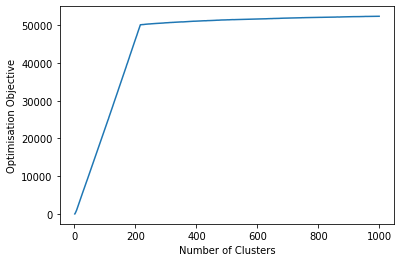

In [ ]:
plt.plot(range(3500,5000,100), cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Optimisation Objective')